# Running cross-validation to estimate performance of system

In [52]:
# Import
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
%matplotlib inline


load_loc = '/Users/sfvn/Dropbox/DeepFactData/annotated/' #SPECIFY PATH TO DATA
with open(load_loc+"data_matrix_sample_programs.pickle",'rb') as f:
        data = pickle.load(f)

In [42]:
X = data['data'][:,4] # sentences
y = data['data'][:,6] # claim indices
N = len(X)

features = data['features']
print(features)

# Now convert y to a binary indicator matrix (1 is claim, 0 no claim)
y = np.asarray([y[i] is not None for i in range(N)])

# Make a Bag-of-Words
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X)
words = vectorizer.get_feature_names()

# Fit the logit model
logistic = linear_model.LogisticRegression()
logistic.fit(X=X_bow,y=y)
ypred = logistic.predict(X_bow) 

# CM on traning data
C = confusion_matrix(y, ypred)
C


['start time', 'end time', 'program_id', 'sentence_id', 'sentence', 'claim_idx', 'claim']
[False False False ..., False False False]


/Users/sfvn/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


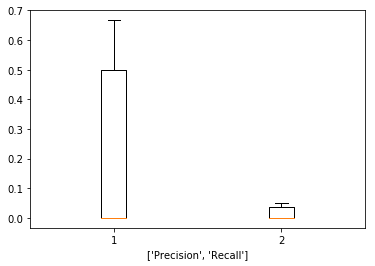

In [54]:
# Get number of programs
program_ids = data['data'][:,2]
unique_programs = np.unique(program_ids)
NUM_PROGRAMS = len(unique_programs)                   
loo = LeaveOneOut()

class_performance_precision = []
class_performance_recall = []

for train,test in loo.split(unique_programs):
    # Extract training and test data
    train_idx = program_ids!=unique_programs[test]
    test_idx = program_ids==unique_programs[test]
    X_test = X_bow[test_idx]
    X_train = X_bow[train_idx]
    y_test = y[test_idx]
    y_train = y[train_idx]
    
    # Train model
    logistic = linear_model.LogisticRegression()
    logistic.fit(X=X_train,y=y_train)
    ypred = logistic.predict(X_test) 

    # Evaluate
    class_performance_precision += [precision_score(y_test,ypred)]
    class_performance_recall += [recall_score(y_test,ypred)]

plt.boxplot( [class_performance_precision, class_performance_recall] )
plt.xlabel( ['Precision', 'Recall'])
plt.show()

In [35]:
unique_programs

array(['program1', 'program2', 'program3', 'program4', 'program5',
       'program6', 'program7'], dtype=object)

In [47]:
class_performance

[0.012499999999999999, 0.02298850574712644, 0.0, 0.0, 0.0, 0.0, 0.0]

## Cross-validation with Tensorflow

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
import numpy as np

def leave_one_program_out_cv(data, model_list, eval_functions = [accuracy_score]):
    
    # Get program ids and number of programs
    program_ids = data['data'][:,2]
    unique_programs = np.unique(program_ids)
    NUM_PROGRAMS = len(unique_programs)                   
    loo = LeaveOneOut()

    classification_results = np.array( (NUM_PROGRAMS, len(model_list), len(eval_functions)))
    tensor_data = data_to_tensors(data)
    
    for train,test in loo.split(unique_programs):
        X_train, X_test, y_train, y_test = extract_train_test(tensor_data,train,test)
        split = 0
        for model in model_list:
            m = 0
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            for evalf in eval_functions:
                e = 0
                classification_results[split,m,e] = eval_functions[e](y_test,y_pred)
                e += 1
                
            m+=1
            
        split+=1

    
def data_to_tensors(data):
    print('Wuhuu')
    return None

def extract_train_test(data)
    return None